LG AI hackathon Smart Factory
[대회 링크](https://dacon.io/competitions/official/236055/overview/description)

# Data Description

**1. train.csv [파일]**
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 제품 품질 상태(Target) 
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)
- Y_Quality : 제품 품질 관련 정량적 수치
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수
- 06.13.2022~09.08.2022 DATA



**2. test.csv [파일]**
- PRODUCT_ID : 제품의 고유 ID
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수
- 09.09.2022~11.05.2022 DATA 

**3. sample_submission.csv [파일] - 제출 양식**
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 예측한 제품 품질 상태
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)

- 실제 공정 과정에서의 데이터로, 보안상의 이유로 일부 변수가 비식별화 처리 되었습니다. (X변수)
- 'LINE', 'PRODUCT_CODE'는 Train / Test 모두 동일한 종류가 존재합니다.

## DATA LEAKAGE - RULE 
1. 대표적인 Data Leakage에 해당하는 사례
    - Label Encoding 시 Test 데이터로부터 Encoder를 fit 시키는 경우
    - Scaler 사용 시 Test 데이터로부터 Scaler를 fit 시키는 경우
    Test 데이터에 대한 결측치 보간 시 Test 데이터의 통계 정보(평균, 최빈값 등)를 사용하는 경우
    - 파생변수를 생성할 시 2개 이상의 Test 데이터들의 정보를 활용할 경우
    - Test 데이터들의 이동 평균을 활용하는 경우
    - Test 데이터들을 모델 학습에 활용하는 경우 (이번 해커톤에서는 Pseudo-Labeling도 허용하지 않습니다)
    - Test 데이터에 pandas의 get_dummies() 함수를 적용하는 경우
        - (=) Test DATA로 Encoder를 fitting 한 것과 같으므로
        - ==> Encoder를 Train data로 fitting 한 후, Test data에 Transform (GOOD)  
    - Test 데이터의 index 정보 혹은 row 개수 정보를 활용하는 경우
    - Test 데이터로부터 EDA를 진행한 결과(인사이트)를 전처리, 모델 학습에 적용하는 경우
    - 이 밖의 Test 데이터들의 정보를 모델 학습에 활용하는 모든 경우


2. 대표적인 Data Leakage에 해당하지 않는 사례
    - 독립적인 샘플(행(row)) 내에서의 모든 연산 혹은 파생 변수 생성
        - 예를 들어, Test['C'] = Test['A'] + Test['B']와 같이 독립적인 샘플 내에서 A Column과 B Column을 더한 새로운 파생 변수 C Column을 생성하는 경우
    - Train 데이터의 통계 정보를 Test 데이터에 적용하여 전처리하는 경우 혹은 파생 변수를 생성하는 경우
    - Test 데이터의 결측치를 Train 데이터의 통계 정보를 바탕으로 보간하는 경우 


# MODULE IMPORT

In [35]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, classification_report, f1_score

import tensorflow as tf 

# warning message delete 
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# google drive mount
from google.colab import drive
drive.mount('/content/drive')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0.Data Load

In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
train_df = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

In [9]:
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
test_df = test_df.drop(columns=['PRODUCT_ID','TIMESTAMP'])

# 1.Preprocessing

In [20]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [11]:
train_df.describe()

,Y_Class,Y_Quality,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
count,598.000000,598.000000,598.000000,598.000000,598.0,598.0,598.000000,598.0,598.000000,598.000000,...,598.000000,598.000000,598.000000,598.000000,598.000000,598.0,0.0,0.0,0.0,0.0
mean,1.025084,0.530896,2.239130,95.071906,0.0,45.0,10.229097,0.0,47.219064,10.028428,...,52.987258,55.537492,51.150000,55.419950,65.392458,1.0,NaN,NaN,NaN,NaN
std,0.565069,0.007401,4.505497,3.136725,0.0,0.0,0.420604,0.0,3.830212,0.166332,...,3.018107,3.425509,2.996354,4.002222,1.928109,0.0,NaN,NaN,NaN,NaN
min,0.000000,0.500856,1.000000,87.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,32.120000,31.700000,32.560000,30.490000,61.670000,1.0,NaN,NaN,NaN,NaN
25%,1.000000,0.527535,2.000000,94.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,53.425000,55.925000,51.460000,56.175000,65.140000,1.0,NaN,NaN,NaN,NaN
50%,1.000000,0.530436,2.000000,95.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,53.425000,55.925000,51.460000,56.175000,65.140000,1.0,NaN,NaN,NaN,NaN
75%,1.000000,0.533433,2.000000,95.000000,0.0,45.0,10.000000,0.0,50.000000,10.000000,...,53.425000,55.925000,51.460000,56.175000,65.140000,1.0,NaN,NaN,NaN,NaN
max,2.000000,0.578841,103.000000,102.000000,0.0,45.0,11.000000,0.0,62.000000,11.000000,...,60.240000,68.660000,60.410000,59.930000,79.750000,1.0,NaN,NaN,NaN,NaN


In [21]:
# # Label Encoding 
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
col = ['LINE', 'PRODUCT_CODE']

for i in col:
    train_df[i] = encoder.fit_transform(train_df[i])
    test_df[i] = encoder.fit_transform(test_df[i])

# # correlation
# # print(train_x[['Y_Quality', 'line_pcode']].corr()) 

# 2.Modeling_ML

In [120]:
X_train = train_df.drop(columns=['Y_Class','Y_Quality'])
y_train = train_df['Y_Quality']

test_x = test_df.drop(columns=['Y_Quality'])

In [121]:
test_x.isnull().sum()

LINE            0
PRODUCT_CODE    0
X_1             0
X_2             0
X_3             0
               ..
X_2871          0
X_2872          0
X_2873          0
X_2874          0
X_2875          0
Length: 2877, dtype: int64

## Y_Quality 예측

In [122]:
from lightgbm import LGBMRegressor

RF = LGBMRegressor(random_state=37).fit(X_train, y_train) 
print('Done.') 

Done.


In [123]:
preds=RF.predict(test_x)  
print('Done.')

Done.


In [124]:
test_x['Y_Quality'] = preds
test_x  

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,Y_Quality
0,5,2,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,...,53.655,51.175,55.605,63.17,1.0,258.7,257.5,261.7,236.3,0.529678
1,4,2,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,...,53.655,51.175,55.605,63.17,1.0,258.7,257.5,261.7,236.3,0.528602
2,4,2,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,...,53.655,51.175,55.605,63.17,1.0,258.7,257.5,261.7,236.3,0.528209
3,0,0,2.0,95.0,0.0,45.0,10.0,0.0,50.0,10.0,...,53.655,51.175,55.605,63.17,1.0,258.7,257.5,261.7,236.3,0.529686
4,1,0,2.0,95.0,0.0,45.0,10.0,0.0,50.0,10.0,...,53.655,51.175,55.605,63.17,1.0,258.7,257.5,261.7,236.3,0.534285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,5,2,2.0,91.0,0.0,45.0,10.0,0.0,51.0,10.0,...,53.655,51.175,55.605,63.17,1.0,258.7,257.5,261.7,236.3,0.529028
306,4,2,2.0,96.0,0.0,45.0,11.0,0.0,45.0,10.0,...,53.655,51.175,55.605,63.17,1.0,258.7,257.5,261.7,236.3,0.528367
307,5,2,2.0,91.0,0.0,45.0,10.0,0.0,50.0,10.0,...,53.655,51.175,55.605,63.17,1.0,258.7,257.5,261.7,236.3,0.528809
308,5,2,2.0,95.0,0.0,45.0,10.0,0.0,51.0,10.0,...,53.655,51.175,55.605,63.17,1.0,258.7,257.5,261.7,236.3,0.528702


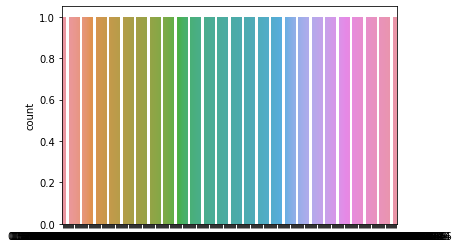

In [125]:
sns.countplot(x=preds);

## 다시 Y_Class 예측

In [150]:
# X_train = train_df
X_train = train_df.drop(columns=['Y_Class'])
y_train = train_df['Y_Class']

In [151]:
X_train = pd.DataFrame(train_df['Y_Quality'])
y_train = train_df['Y_Class']   

In [152]:
X_train.isnull().sum()

Y_Quality    0
dtype: int64

In [153]:
X_train

,Y_Quality
0,0.533433
1,0.541819
2,0.531267
3,0.537325
4,0.531590
...,...
593,0.526546
594,0.524022
595,0.521289
596,0.531375


In [154]:
from lightgbm import LGBMClassifier

RF =  LGBMClassifier(random_state=37).fit(X_train, y_train)
print('Done.')

Done.


In [156]:
# test_x
# test_x = test_x['Y_Quality']
# test_x = test_x.drop(columns=['LINE//','PRODUCT_CODE'])
# test_x = test_x['Y_Quality']  
test_x

0      0.529678
1      0.528602
2      0.528209
3      0.529686
4      0.534285
         ...   
305    0.529028
306    0.528367
307    0.528809
308    0.528702
309    0.528607
Name: Y_Quality, Length: 310, dtype: float64

In [157]:
test_x = pd.DataFrame(test_x)

preds = RF.predict(test_x)  
print('Done.')   

Done.


In [158]:
preds

array([1, 1, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

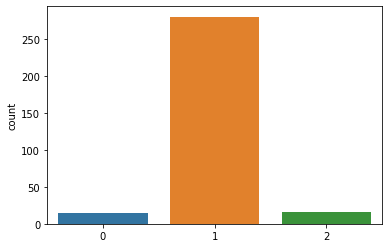

In [159]:
sns.countplot(x=preds);

In [144]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')  

submit['Y_Class'] = preds 
submit.to_csv('smartFactory_submission.csv', index=False)  

## 2.2 LGBM

In [97]:
# X_train = train_df
X_train = train_df.drop(columns=['Y_Class', 'Y_Quality'])
y_train = train_df[ 'Y_Quality']

X_train

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    test_size=0.2,
                                                    random_state=2023)


In [100]:
LGBM_predict

AttributeError: ignored

In [98]:
# hyperparameter - sensitive to setting
## ==> setting is recommended.
from lightgbm import LGBMRegressor

LGBM_model = LGBMRegressor()
LGBM_model.fit(X_train, y_train) 

LGBM_predict = tf.cast(LGBM_model.predict(X_test) > 0.5, 
                       dtype = tf.float32)

print('Accuracy = ', accuracy_score(LGBM_predict, y_test))
print('Test Report = \n', classification_report(LGBM_predict, y_test))

ValueError: ignored

In [ ]:
test_x

In [107]:
# test_x = np.array(test_df, dtype=np.float32)
selected_model = LGBM_model 

preds = selected_model.predict(X_test)  
preds

array([0.53310923, 0.53223024, 0.5260877 , 0.52744809, 0.53759755,
       0.52917383, 0.54680975, 0.53308618, 0.52643875, 0.52535791,
       0.5309208 , 0.53306318, 0.53079174, 0.52536068, 0.5274276 ,
       0.52877657, 0.5308988 , 0.52890682, 0.53804044, 0.52789641,
       0.52463569, 0.54101943, 0.52850936, 0.52402062, 0.53225013,
       0.53200989, 0.53158695, 0.53260727, 0.52427421, 0.53761232,
       0.53054934, 0.53043546, 0.53486683, 0.53679109, 0.53160065,
       0.53550438, 0.53568535, 0.52527255, 0.52839768, 0.53253834,
       0.5302371 , 0.52947414, 0.53280961, 0.53011716, 0.5395518 ,
       0.54453405, 0.5303831 , 0.52895279, 0.53313805, 0.53021627,
       0.52955482, 0.53063437, 0.53307292, 0.53447204, 0.52469023,
       0.52538527, 0.53126407, 0.52940268, 0.52975659, 0.53372918,
       0.52838287, 0.53283463, 0.53448245, 0.53021195, 0.52735026,
       0.53508706, 0.55020271, 0.52562205, 0.52936526, 0.52141026,
       0.52979985, 0.52966006, 0.53099211, 0.52804962, 0.53160

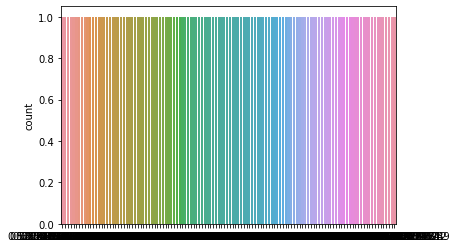

In [108]:
sns.countplot(x=preds);

In [109]:
# X_train = train_df
X_train = train_df.drop(columns=['Y_Class'])
y_train = train_df['Y_Class']

In [110]:
X_train = pd.DataFrame(train_df['Y_Quality'])
y_train = train_df['Y_Class']   

In [112]:
# hyperparameter - sensitive to setting
## ==> setting is recommended.
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model.fit(X_train, y_train) 

LGBM_predict = tf.cast(LGBM_model.predict(X_test) > 0.5, 
                       dtype = tf.float32)

print('Accuracy = ', accuracy_score(LGBM_predict, y_test))
print('Test Report = \n', classification_report(LGBM_predict, y_test))

ValueError: ignored

## 2.3 XGBoost

In [80]:
# hyperparameter setting isn't needed. 
from xgboost import XGBClassifier

Xgboost_model = XGBClassifier()
Xgboost_model.fit(X_train, y_train, eval_metric='aucpr')

Xg_predict = tf.cast(Xgboost_model.predict(X_test) > 0.5, 
                     dtype = tf.float32)

print('Accuracy = ', accuracy_score(Xg_predict, y_test))
print('Test Report = \n', classification_report(Xg_predict, y_test))

Accuracy =  0.725
Test Report = 
               precision    recall  f1-score   support

         0.0       0.40      0.67      0.50         9
         1.0       1.00      0.73      0.84       111
         2.0       0.00      0.00      0.00         0

    accuracy                           0.73       120
   macro avg       0.47      0.47      0.45       120
weighted avg       0.95      0.72      0.82       120



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [135]:
# test_x = np.array(test_df, dtype=np.float32)
selected_model = Xgboost_model 

preds = test_x['Y_Quality']  
preds

0      0.529678
1      0.528602
2      0.528209
3      0.529686
4      0.534285
         ...   
305    0.529028
306    0.528367
307    0.528809
308    0.528702
309    0.528607
Name: Y_Quality, Length: 310, dtype: float64

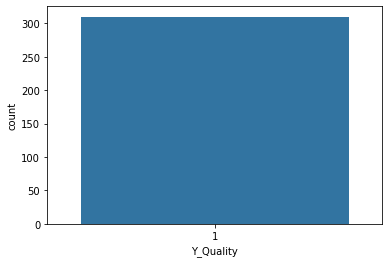

In [105]:
sns.countplot(x=preds);